# Anggota Kelompok

| Name                          | Value      |
| ----------------------------- | ---------- |
| Cakra Wangsa May Ahmad Widodo | 2341720032 |
| Hamdan Azizul Hakim           | 2341720251 |
| Hidayat Widi Saputra          | 2341720157 |
| Marsya Aurelia Sefira         | 2341720011 |


# Persiapan

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [ ]:
import kagglehub

path = kagglehub.dataset_download("ankushpanday2/heart-attack-prediction-in-indonesia")

print("Path to dataset files:", path)

def load_data():
  # List files in the dataset directory
  files = os.listdir(path)
  print("Files in the dataset directory:", files)

  # Assuming the dataset is in a CSV file, read the first CSV file found
  csv_files = [f for f in files if f.endswith('.csv')]

  if csv_files:
      dataset_path = os.path.join(path, csv_files[0])
      df = pd.read_csv(dataset_path)

      # Display all data, including NaN values
      display(df)
      return df

  else:
      print("No CSV files found in the dataset directory.")

d:\NaniKaSuru\tmp\MLSinta3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.15M/5.15M [00:06<00:00, 898kB/s] 

Extracting files...
Path to dataset files: C:\Users\Raruu\.cache\kagglehub\datasets\ankushpanday2\heart-attack-prediction-in-indonesia\versions\1


# KMeans

In [ ]:
#@markdown # K-MEANS Helper Function

def preprocess_data_for_kmeans(df, max_samples=None):
    """
    Encodes categorical columns and scales numerical data for K-Means.

    Args:
        df (pd.DataFrame): Input dataframe.
        max_samples (int, optional): Number of samples to take for clustering.

    Returns:
        tuple: (scaled_data_df, processed_df_with_encodings, label_encoders)
    """
    df_selected = df.copy()

    # Limit number of samples
    if max_samples is not None and max_samples < len(df_selected):
        df_selected = df_selected.sample(max_samples, random_state=42)
        print(f"Using a sample of {max_samples} data points for clustering.")

    # Label encode categorical columns
    label_encoders = {}
    for col in df_selected.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_selected[col] = le.fit_transform(df_selected[col])
        label_encoders[col] = le

    # Standardize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_selected)
    df_scaled = pd.DataFrame(df_scaled, columns=df_selected.columns)

    return df_scaled, df_selected, label_encoders


def test_elbow_and_silhouette(df_scaled, k_min=2, k_max=10):
    """
    Tests multiple K values using Elbow and Silhouette methods.

    Args:
        df_scaled (pd.DataFrame): Scaled dataset.
        k_min (int): Minimum K value to test.
        k_max (int): Maximum K value to test.

    Returns:
        dict: Dictionary containing 'K', 'inertia', and 'silhouette_scores'
    """
    inertia = []
    silhouette_scores = []
    K = range(k_min, k_max + 1)

    print("=== Testing Elbow and Silhouette Scores ===")
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)

        labels = kmeans.predict(df_scaled)
        score = silhouette_score(df_scaled, labels, sample_size=min(10000, len(df_scaled)), random_state=42)
        silhouette_scores.append(score)
        print(f"K={k} → Silhouette Score = {score:.4f}")

    # Plot Elbow
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bo-')
    plt.title("Elbow Method - Tentukan k Optimal")
    plt.xlabel("Jumlah Cluster")
    plt.ylabel("Inertia")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Plot Silhouette
    plt.figure(figsize=(8, 5))
    plt.plot(K, silhouette_scores, 'ro-')
    plt.title("Silhouette Scores for Different K")
    plt.xlabel("Jumlah Cluster")
    plt.ylabel("Silhouette Score")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    return {
        'K': list(K),
        'inertia': inertia,
        'silhouette_scores': silhouette_scores
    }


def perform_kmeans_clustering(df, kmeans_params, max_samples=None):
    """
    Performs K-Means clustering and visualizes results with PCA.

    Args:
        df (pd.DataFrame): Input dataframe.
        kmeans_params (dict): Parameters for KMeans.
        max_samples (int, optional): Limit sample size for clustering.

    Returns:
        pd.DataFrame: Dataframe with cluster labels and PCA components.
    """
    df_scaled, df_selected, label_encoders = preprocess_data_for_kmeans(df, max_samples)

    kmeans = KMeans(**kmeans_params, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(df_scaled)
    df_selected['cluster'] = cluster_labels

    if df_scaled.shape[1] > 2:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(df_scaled)
        df_selected['pca1'] = pca_result[:, 0]
        df_selected['pca2'] = pca_result[:, 1]
    else:
        df_selected['pca1'] = df_scaled.iloc[:, 0]
        df_selected['pca2'] = df_scaled.iloc[:, 1] if df_scaled.shape[1] > 1 else 0

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_selected, x='pca1', y='pca2', hue='cluster', palette='Set1', alpha=0.7)
    plt.title(f'Visualisasi Hasil Clustering KMeans (K={kmeans_params["n_clusters"]})')
    plt.show()

    return df_selected, label_encoders


In [ ]:
#@markdown # Helper Function Validasi Hasil Clustering

def evaluate_clustering_as_classification(true_labels, cluster_labels):
    """
    Evaluasi hasil clustering sebagai tugas klasifikasi.

    Args:
        true_labels (array-like): Label sebenarnya (misal: 'heart_attack').
        cluster_labels (array-like): Label cluster dari hasil K-Means.
    """

    # Karena K-Means tidak memiliki label intrinsik, kita perlu memetakan
    # label cluster ke label sebenarnya berdasarkan mayoritas.
    # Ini hanya pendekatan dan mungkin tidak sempurna.
    # Kita asumsikan ada 2 cluster yang sesuai dengan 0 dan 1 dari true_labels.

    # Buat DataFrame sementara untuk mempermudah pemetaan
    temp_df = pd.DataFrame({'true': true_labels, 'cluster': cluster_labels})

    # Temukan pemetaan terbaik antara cluster dan true labels
    # Hitung jumlah true labels per cluster
    mapping = temp_df.groupby('cluster')['true'].value_counts().unstack(fill_value=0)

    # Tentukan label true yang paling sering muncul di setiap cluster
    cluster_to_true = mapping.idxmax(axis=1)

    # Terapkan pemetaan ke label cluster
    mapped_cluster_labels = temp_df['cluster'].map(cluster_to_true)

    # Evaluasi metrik klasifikasi
    accuracy = accuracy_score(true_labels, mapped_cluster_labels)
    precision = precision_score(true_labels, mapped_cluster_labels)
    recall = recall_score(true_labels, mapped_cluster_labels)
    f1 = f1_score(true_labels, mapped_cluster_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, mapped_cluster_labels))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, mapped_cluster_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Interpretasi Confusion Matrix
    tn, fp, fn, tp = cm.ravel()
    print("\nInterpretasi Confusion Matrix:")
    print(f"True Positives (TP): {tp} - Jumlah kasus Serangan Jantung yang diprediksi dengan benar.")
    print(f"True Negatives (TN): {tn} - Jumlah kasus Bukan Serangan Jantung yang diprediksi dengan benar.")
    print(f"False Positives (FP): {fp} - Jumlah kasus Bukan Serangan Jantung yang salah diprediksi sebagai Serangan Jantung.")
    print(f"False Negatives (FN): {fn} - Jumlah kasus Serangan Jantung yang salah diprediksi sebagai Bukan Serangan Jantung.")

# Example usage (assuming 'df' is your DataFrame with 'heart_attack' and 'cluster' columns):
# evaluate_clustering_as_classification(df['heart_attack'], df['cluster'])

Files in the dataset directory: ['heart_attack_prediction_indonesia.csv']


,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158350,60,Female,Rural,Middle,0,0,199,0,79,0,...,74,79,52,238,234,Normal,0,1,0,0
158351,64,Female,Urban,Low,0,0,179,0,93,0,...,73,111,41,177,239,Normal,0,1,1,1
158352,30,Male,Urban,Middle,0,0,220,0,78,0,...,87,127,50,158,201,Abnormal,1,1,1,1
158353,74,Male,Urban,Middle,0,0,180,0,58,1,...,70,119,52,153,171,Normal,1,0,1,1


alcohol_consumption
NaN         94848
Moderate    47725
High        15782
Name: count, dtype: int64

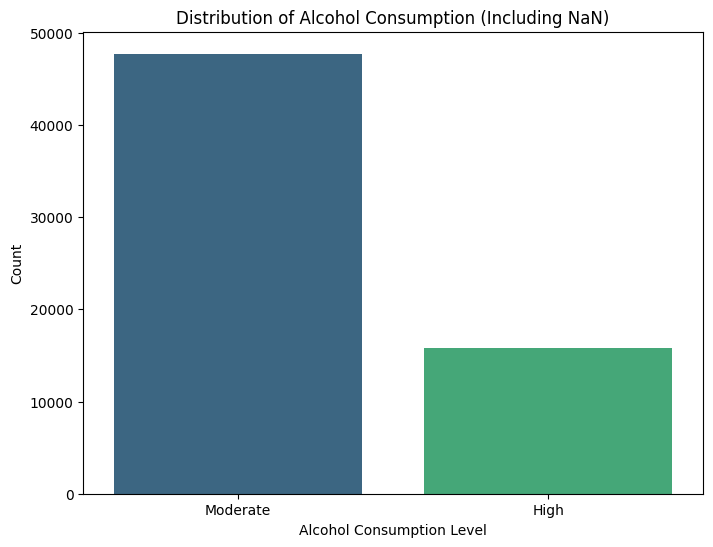

In [ ]:
df = load_data()

# Display the count of each unique value in the 'alcohol_consumption' column, including NaN
alcohol_counts = df['alcohol_consumption'].value_counts(dropna=False)
display(alcohol_counts)

# Create a bar plot to visualize the distribution, including NaN
plt.figure(figsize=(8, 6))
# Replace NaN index with a string representation for better labeling
alcohol_counts_labeled = alcohol_counts.rename({float('nan'): 'NaN'})
sns.barplot(x=alcohol_counts_labeled.index, y=alcohol_counts_labeled.values, palette='viridis', hue=alcohol_counts_labeled.index, legend=False)
plt.title('Distribution of Alcohol Consumption (Including NaN)')
plt.xlabel('Alcohol Consumption Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



## Pra-pemprosesan data

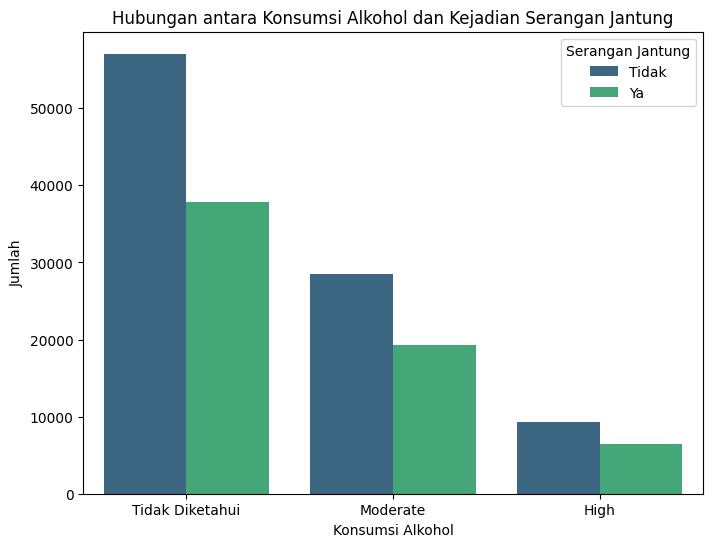

In [ ]:
# Replace NaN values with a string category like 'Unknown' or 'Not Specified'
df['alcohol_consumption'] = df['alcohol_consumption'].fillna('Tidak Diketahui')

# Create a count plot to show the relationship between alcohol_consumption and heart_attack
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='alcohol_consumption', hue='heart_attack', palette='viridis')
plt.title('Hubungan antara Konsumsi Alkohol dan Kejadian Serangan Jantung')
plt.xlabel('Konsumsi Alkohol')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.legend(title='Serangan Jantung', labels=['Tidak', 'Ya'])
plt.show()

In [ ]:
columns_to_drop = [
    'age',
    'gender',
    'region',
    'income_level',
    'EKG_results',
    'participated_in_free_screening',
    'heart_attack'
]

df_copy = df.copy()
df_copy = df_copy.drop(columns=columns_to_drop)

## Lihat elbow

=== Testing Elbow and Silhouette Scores ===
K=2 → Silhouette Score = 0.0717
K=3 → Silhouette Score = 0.0699
K=4 → Silhouette Score = 0.0556
K=5 → Silhouette Score = 0.0434
K=6 → Silhouette Score = 0.0378
K=7 → Silhouette Score = 0.0329
K=8 → Silhouette Score = 0.0338
K=9 → Silhouette Score = 0.0333
K=10 → Silhouette Score = 0.0344


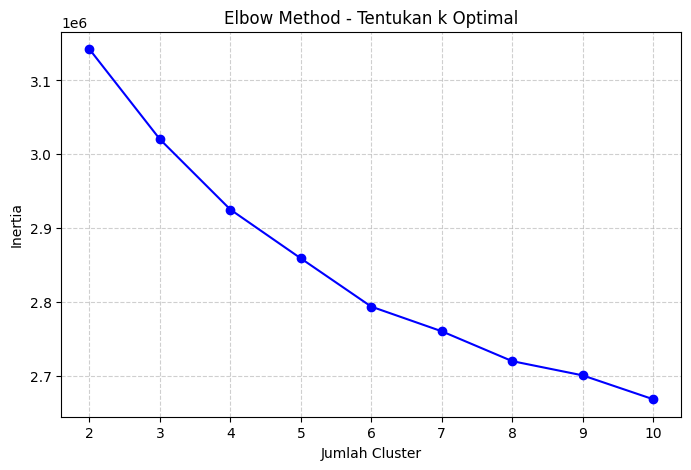

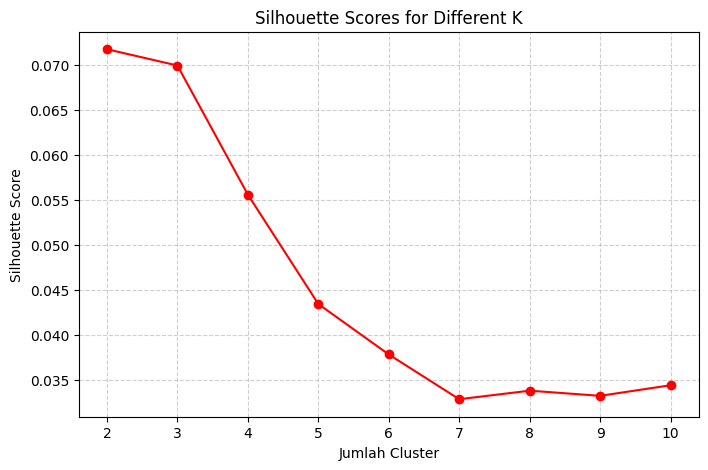

{'K': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'inertia': [3142322.7040523826,
  3020238.472469596,
  2924995.6256377995,
  2858809.738024087,
  2793416.9674940812,
  2759996.5511788432,
  2719526.2939688107,
  2700229.607077947,
  2667893.1038654777],
 'silhouette_scores': [0.07170447199206433,
  0.06989666651238649,
  0.05557827704134728,
  0.04344710002600127,
  0.03784910174918995,
  0.03288641031706849,
  0.03383418952427072,
  0.03326172371962407,
  0.03443861804611724]}

In [ ]:
df_scaled, _, _ = preprocess_data_for_kmeans(df_copy)

_ = test_elbow_and_silhouette(df_scaled, 2, 10)

## Menjalankan KMeans

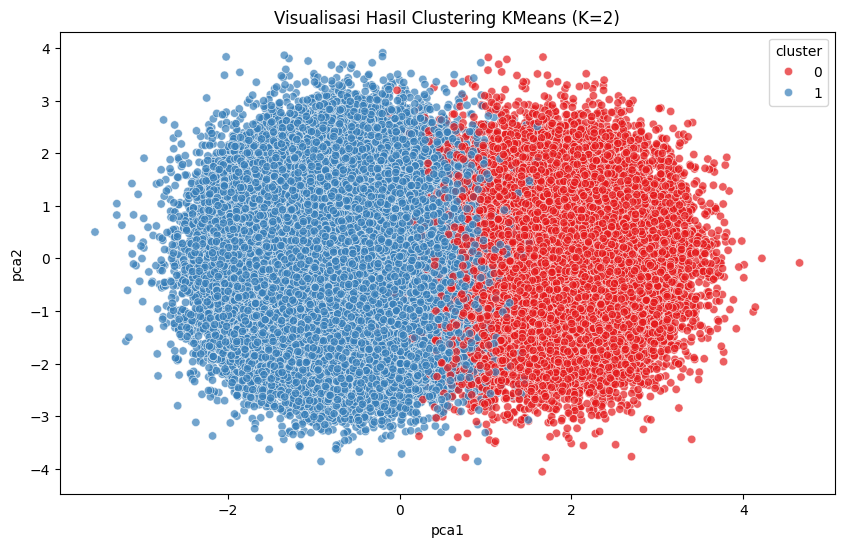

In [ ]:
df_cluster, _ = perform_kmeans_clustering(df_copy, {'n_clusters':2, 'random_state':42})

## Visualisasi

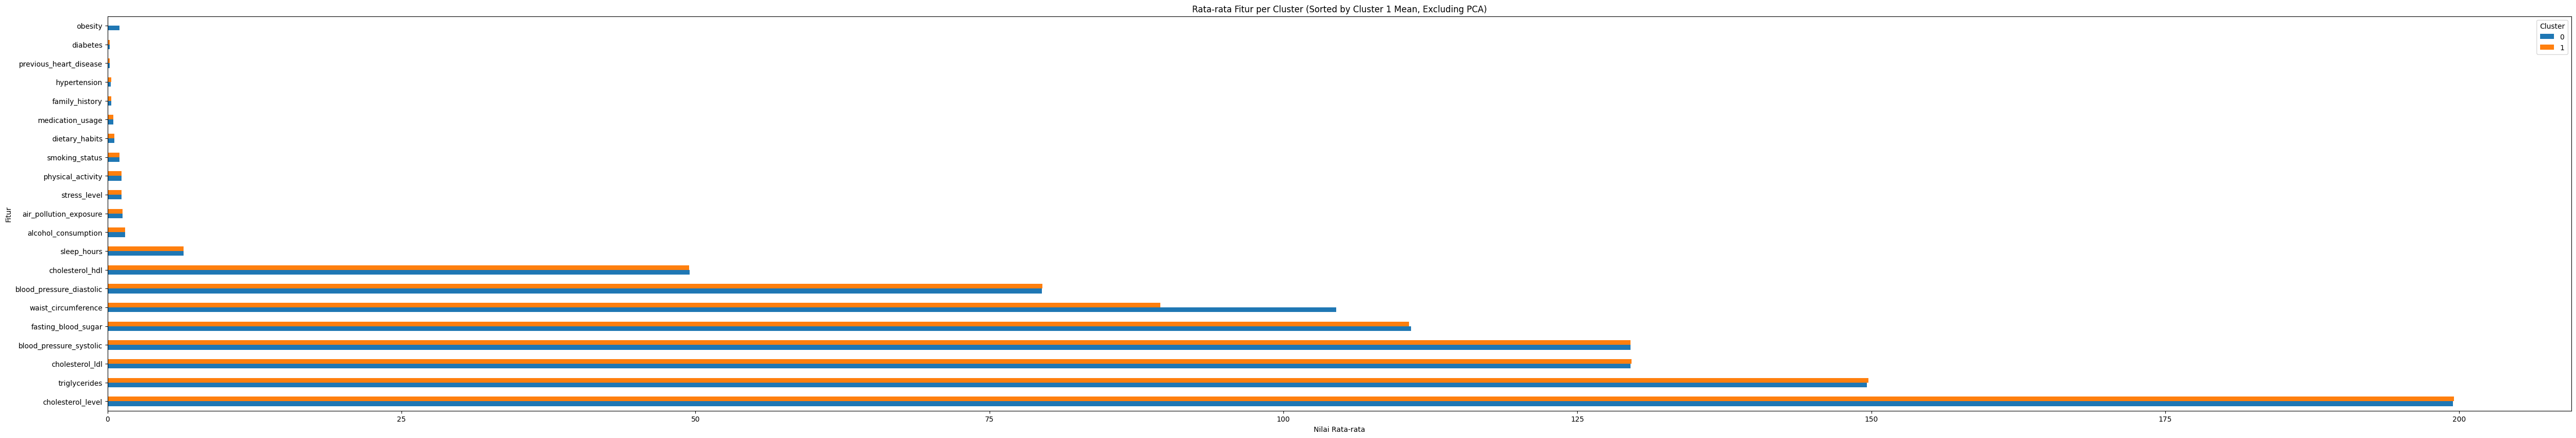

In [ ]:
cluster_summary = df_cluster.groupby('cluster').mean()

cluster_summary_sorted = cluster_summary.drop(columns=['pca1', 'pca2']).T.sort_values(by=1, ascending=False)

cluster_summary_sorted.plot(kind='barh', figsize=(62, 10))
plt.title('Rata-rata Fitur per Cluster (Sorted by Cluster 1 Mean, Excluding PCA)')
plt.xlabel('Nilai Rata-rata')
plt.ylabel('Fitur')
plt.legend(title='Cluster')
plt.show()

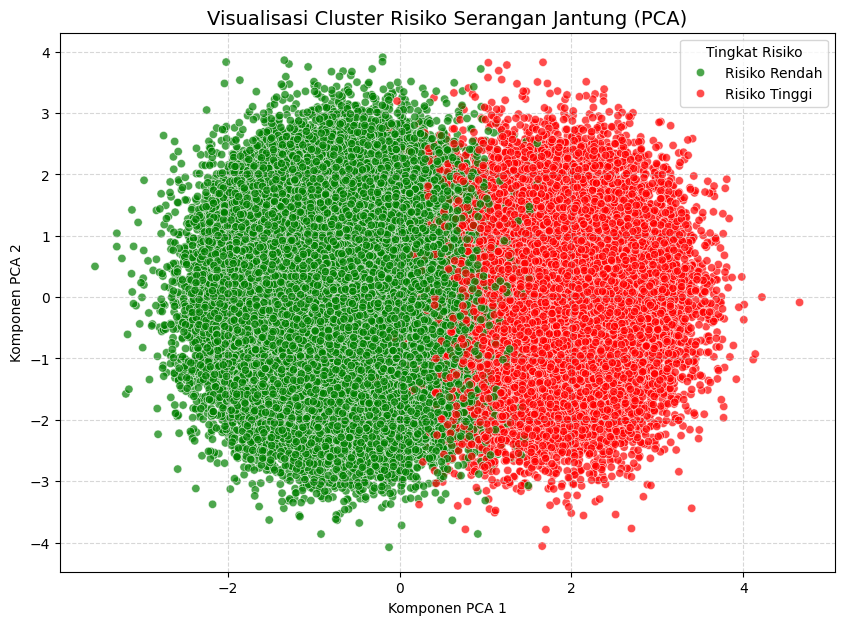

In [ ]:
# Mapping label cluster dengan interpretasi risiko
# Berdasarkan analisis cluster_summary, Cluster 0 memiliki rata-rata obesitas dan lingkar pinggang yang lebih tinggi
# sehingga mungkin mewakili risiko yang lebih tinggi.
df_cluster['cluster_label'] = df_cluster['cluster'].map({
    0: 'Risiko Tinggi',  # Diubah menjadi Risiko Tinggi
    1: 'Risiko Rendah'   # Diubah menjadi Risiko Rendah
})

# display(df_cluster[['cluster', 'cluster_label']].head())

# Visualisasi hasil clustering dengan label risiko
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='cluster_label',     # pakai label risiko
    palette={'Risiko Tinggi': 'red', 'Risiko Rendah': 'green'}, # Sesuaikan palet warna
    data=df_cluster, # Use df_cluster here
    alpha=0.7
)

plt.title('Visualisasi Cluster Risiko Serangan Jantung (PCA)', fontsize=14)
plt.xlabel('Komponen PCA 1')
plt.ylabel('Komponen PCA 2')
plt.legend(title='Tingkat Risiko', loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Accuracy: 0.6223
Precision: 0.5467
Recall: 0.3408
F1-Score: 0.4199

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     94854
           1       0.55      0.34      0.42     63501

    accuracy                           0.62    158355
   macro avg       0.60      0.58      0.57    158355
weighted avg       0.61      0.62      0.60    158355



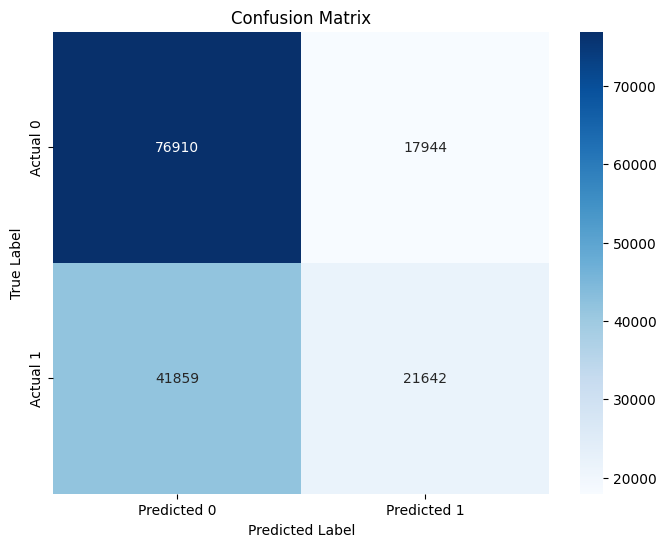


Interpretasi Confusion Matrix:
True Positives (TP): 21642 - Jumlah kasus Serangan Jantung yang diprediksi dengan benar.
True Negatives (TN): 76910 - Jumlah kasus Bukan Serangan Jantung yang diprediksi dengan benar.
False Positives (FP): 17944 - Jumlah kasus Bukan Serangan Jantung yang salah diprediksi sebagai Serangan Jantung.
False Negatives (FN): 41859 - Jumlah kasus Serangan Jantung yang salah diprediksi sebagai Bukan Serangan Jantung.


In [ ]:
evaluate_clustering_as_classification(df['heart_attack'], df_cluster['cluster'])

## Kesimpulan K-Means
Setelah melakukan K-Means dengan menghilangkan beberapa fitur yang kurang relevan untuk risiko (age, gender, region, income_level, EKG_results, participated_in_free_screening, dan heart_attack), dapat disimpulkan:

**1. Pemilihan Jumlah Cluster (K):**

*   Metode Elbow menunjukkan adanya "siku" di sekitar K=2.
*   Skor Silhouette tertinggi juga diperoleh pada K=2 sebesar 0.0717.

**2. Karakteristik Cluster (K=2):**

*   Berdasarkan rata-rata fitur pada kedua cluster, Cluster 0 memiliki nilai rata-rata yang lebih tinggi pada fitur-fitur terkait obesitas (obesitas, lingkar pinggang) dibandingkan dengan Cluster 1.
*   Oleh karena itu, **Cluster 0 diinterpretasikan sebagai kelompok dengan Risiko Tinggi**, sementara **Cluster 1 diinterpretasikan sebagai kelompok dengan Risiko Rendah**.

**3. Visualisasi Cluster (menggunakan PCA):**

*   Plot PCA menunjukkan adanya sedikit pemisahan antara kedua cluster, namun masih terdapat banyak tumpang tindih. Hal ini konsisten dengan skor Silhouette yang rendah, menunjukkan bahwa fitur yang digunakan belum sepenuhnya memisahkan kedua kelompok risiko ini dengan jelas.

**4. Evaluasi Clustering sebagai Klasifikasi (Terhadap Label Serangan Jantung Aktual):**

*   Meskipun clustering adalah tugas unsupervised, kami mengevaluasinya terhadap label 'heart_attack' yang sebenarnya sebagai validasi eksternal (hanya untuk melihat sejauh mana cluster yang terbentuk relevan dengan label asli).
*   Dengan memetakan cluster ke label 'heart_attack' (berdasarkan mayoritas label asli di setiap cluster), diperoleh metrik klasifikasi sebagai berikut:
    *   Accuracy: Sekitar 0.62
    *   Precision (untuk kelas Serangan Jantung): Sekitar 0.54
    *   Recall (untuk kelas Serangan Jantung): Sekitar 0.34
    *   F1-Score (untuk kelas Serangan Jantung): Sekitar 0.41

*   **Interpretasi:**
    *   Accuracy 0.62 menunjukkan bahwa sekitar 62% sampel dikelompokkan dengan benar jika kita menganggap cluster sebagai prediksi risiko.
    *   Recall 0.34 berarti hanya sekitar 34% dari kasus Serangan Jantung yang sebenarnya berhasil dikelompokkan ke dalam cluster 'Risiko Tinggi'. Ini menunjukkan model clustering kesulitan dalam menangkap semua kasus positif.
    *   Precision 0.54 berarti sekitar 54% dari sampel yang dikelompokkan ke dalam cluster 'Risiko Tinggi' memang merupakan kasus Serangan Jantung yang sebenarnya.
    *   Confusion Matrix menunjukkan adanya jumlah False Negatives yang cukup tinggi, sekitar 41859 pada sampel 158355 data.

**Kesimpulan Akhir:**

Meskipun K-Means berhasil membagi data menjadi dua cluster berdasarkan pola fitur yang ada, pemisahan ini belum sepenuhnya selaras dengan label 'heart_attack' yang sebenarnya. Cluster yang diidentifikasi sebagai 'Risiko Tinggi' memang memiliki karakteristik yang secara intuitif terkait dengan risiko (seperti obesitas), namun model kesulitan mengidentifikasi semua individu yang benar-benar mengalami serangan jantung.


# DBSCAN

### Pra-pemrosesan Data

In [ ]:
df = load_data()

if 'df' in locals():
    print("\n--- Langkah 3: Pra-pemrosesan Data ---")

    # 3.1 Validasi & normalisasi label target menjadi biner 0/1
    target_col = 'heart_attack'
    if target_col not in df.columns:
        raise KeyError(f"Kolom target '{target_col}' tidak ditemukan di dataset.")

    y_raw = df[target_col].copy()

    # Jika bertipe string/kategori, peta ke 0/1
    if not np.issubdtype(y_raw.dtype, np.number):
        mapping_yes = {
            'yes': 1, 'y': 1, 'true': 1, 't': 1, '1': 1, 'ya': 1, 'serangan': 1, 'positif': 1
        }
        mapping_no = {
            'no': 0, 'n': 0, 'false': 0, 'f': 0, '0': 0, 'tidak': 0, 'negatif': 0
        }
        def map_to_binary(val):
            if pd.isna(val):
                return np.nan
            s = str(val).strip().lower()
            if s in mapping_yes:
                return 1
            if s in mapping_no:
                return 0
            # fallback: coba cast ke int jika memungkinkan
            try:
                iv = int(float(s))
                return 1 if iv != 0 else 0
            except Exception:
                return np.nan
        y = y_raw.map(map_to_binary)
    else:
        # numerik -> pastikan 0/1
        y = y_raw.copy()
        y = y.fillna(0)
        # segala nilai != 0 dianggap 1
        y = (y.astype(float) != 0).astype(int)

    if y.isna().any():
        # imputasi label yang NaN (jika ada) dengan modus
        mode_val = int(y.mode(dropna=True)[0])
        y = y.fillna(mode_val)

    # Tampilkan ringkasan label
    print("Ringkasan label target (0 = Tidak, 1 = Serangan):")
    print(y.value_counts().sort_index())

    # 3.2 Pisahkan fitur dan target
    X = df.drop(columns=[target_col])

    # 3.3 Identifikasi tipe fitur
    numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Ditemukan {len(numerical_features)} fitur numerik dan {len(categorical_features)} fitur kategorikal.")

    # 3.4 Transformer numerik & kategorikal
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # OneHotEncoder: dukung versi scikit-learn lama/baru
    try:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        # fallback untuk versi lama yang pakai 'sparse'
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

    # 3.5 Fit-transform -> hasilkan array dense agar kompatibel untuk DBSCAN & kNN
    X_processed = preprocessor.fit_transform(X)
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()

    print("\n✅ Pra-pemrosesan selesai (Imputasi, Skala, One-Hot Encoding).")
    print(f"Dimensi data setelah diproses: {X_processed.shape}")
    print(f"Tipe data: {type(X_processed)}")

    # simpan untuk langkah berikutnya & kompatibilitas sel lama
    true_labels = y.values
else:
    print("Data tidak dimuat pada Langkah 1, langkah ini dilewati.")

Files in the dataset directory: ['heart_attack_prediction_indonesia.csv']


,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158350,60,Female,Rural,Middle,0,0,199,0,79,0,...,74,79,52,238,234,Normal,0,1,0,0
158351,64,Female,Urban,Low,0,0,179,0,93,0,...,73,111,41,177,239,Normal,0,1,1,1
158352,30,Male,Urban,Middle,0,0,220,0,78,0,...,87,127,50,158,201,Abnormal,1,1,1,1
158353,74,Male,Urban,Middle,0,0,180,0,58,1,...,70,119,52,153,171,Normal,1,0,1,1



--- Langkah 3: Pra-pemrosesan Data ---
Ringkasan label target (0 = Tidak, 1 = Serangan):
heart_attack
0    94854
1    63501
Name: count, dtype: int64
Ditemukan 17 fitur numerik dan 10 fitur kategorikal.

✅ Pra-pemrosesan selesai (Imputasi, Skala, One-Hot Encoding).
Dimensi data setelah diproses: (158355, 42)
Tipe data: <class 'numpy.ndarray'>


## Menentukan Parameter Optimal DBSCAN (eps)

In [ ]:
if 'X_processed' in locals():
    print("\n--- Langkah 4: Menentukan Parameter Optimal DBSCAN (eps & min_samples) ---")

    from sklearn.metrics import accuracy_score, f1_score
    from sklearn.neighbors import NearestNeighbors

    Xp = X_processed
    n_samples = Xp.shape[0]
    n_features = Xp.shape[1]

    # 4.1 k-distance untuk estimasi skala eps
    # gunakan k yang moderat agar komputasi efisien
    k = min(max(5, int(0.02 * n_samples)), 50)
    try:
        nn = NearestNeighbors(n_neighbors=k)
        nn.fit(Xp)
        dists, _ = nn.kneighbors(Xp)
        kth = np.sort(dists[:, -1])
        # pertimbangkan beberapa persentil sebagai kandidat eps
        percentiles = [60, 65, 70, 75, 80, 85, 90]
        eps_candidates = [float(np.percentile(kth, p)) for p in percentiles]
    except Exception as e:
        print(f"Gagal menghitung k-distance: {e}. Gunakan fallback eps candidates.")
        eps_candidates = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]

    # 4.2 kandidat min_samples: fungsi fitur & proporsi sampel
    min_samples_candidates = sorted(set([
        5,
        2 * n_features,
        max(5, int(0.01 * n_samples)),
        max(5, int(0.02 * n_samples)),
        max(5, int(0.03 * n_samples))
    ]))

    print(f"Kandidat eps: {np.round(eps_candidates, 4)}")
    print(f"Kandidat min_samples: {min_samples_candidates}")

    # 4.3 grid search ringan untuk memilih parameter yang menghasilkan 2 cluster (tanpa menghitung noise)

    best = {
        'score': -1.0,
        'eps': None,
        'min_samples': None,
        'n_clusters_wo_noise': None
    }

    y_true = true_labels

    for eps in eps_candidates:
        for ms in min_samples_candidates:
            model = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
            labels = model.fit_predict(Xp)

            # hitung cluster unik tidak termasuk noise (-1)
            unique = [c for c in np.unique(labels) if c != -1]
            ncl = len(unique)

            if ncl == 0:
                continue

            # jika bukan 2 cluster, tetap evaluasi namun prioritaskan ncl==2 nanti
            # map cluster -> pred label via mayoritas untuk hitung metrik
            pred = labels.copy()
            # assign noise temporer ke cluster mayoritas global agar bisa hitung metrik
            if np.any(pred == -1):
                # cari cluster dengan ukuran terbesar (bukan -1)
                sizes = [(c, np.sum(pred == c)) for c in unique]
                if sizes:
                    maj_cluster = max(sizes, key=lambda x: x[1])[0]
                    pred[pred == -1] = maj_cluster

            # majority vote mapping to 0/1
            cluster_to_label = {}
            for c in np.unique(pred):
                mask = (pred == c)
                maj = int(pd.Series(y_true[mask]).mode()[0])
                cluster_to_label[c] = maj
            y_pred = np.array([cluster_to_label[c] for c in pred])

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            # skor gabungan simple
            score = 0.6 * f1 + 0.4 * acc

            # strategi seleksi: utamakan ncl==2; jika sama, pilih skor lebih tinggi; jika sama, ms lebih kecil, lalu eps lebih kecil
            better = False
            if best['eps'] is None:
                better = True
            else:
                if (ncl == 2 and best['n_clusters_wo_noise'] != 2):
                    better = True
                elif (ncl == best['n_clusters_wo_noise']):
                    if score > best['score'] + 1e-6:
                        better = True
                    elif abs(score - best['score']) <= 1e-6:
                        if ms < best['min_samples']:
                            better = True
                        elif ms == best['min_samples'] and eps < best['eps']:
                            better = True
                elif (best['n_clusters_wo_noise'] != 2 and ncl != 0 and ncl < (best['n_clusters_wo_noise'] or 1e9)):
                    # jika belum dapat 2 cluster, pilih ncl paling dekat ke 2 dari atas
                    better = True

            if better:
                best.update({'score': score, 'eps': eps, 'min_samples': ms, 'n_clusters_wo_noise': ncl})

    print("\nHasil pemilihan parameter sementara:")
    print(best)

    # simpan
    optimal_eps = best['eps'] if best['eps'] is not None else (eps_candidates[len(eps_candidates)//2])
    optimal_min_samples = best['min_samples'] if best['min_samples'] is not None else min_samples_candidates[0]

    print(f"\n✅ Parameter terpilih -> eps={optimal_eps}, min_samples={optimal_min_samples}, cluster tanpa noise={best['n_clusters_wo_noise']}")
else:
    print("Data belum diproses, langkah ini dilewati.")


--- Langkah 4: Menentukan Parameter Optimal DBSCAN (eps & min_samples) ---
Kandidat eps: [3.9253 3.9763 4.0311 4.0918 4.1601 4.2405 4.3445]
Kandidat min_samples: [5, 84, 1583, 3167, 4750]

Hasil pemilihan parameter sementara:
{'score': 0.2395983707492659, 'eps': 3.925334269674731, 'min_samples': 5, 'n_clusters_wo_noise': 1}

✅ Parameter terpilih -> eps=3.925334269674731, min_samples=5, cluster tanpa noise=1


## Menjalankan DBSCAN dan Menganalisis Hasil Awal

In [ ]:
# Sel 5
if 'X_processed' in locals() and 'true_labels' in locals():
    print("\n--- Langkah 5: Menjalankan DBSCAN (dengan parameter terpilih) ---")

    eps = optimal_eps if 'optimal_eps' in locals() else 0.5
    min_samples = optimal_min_samples if 'optimal_min_samples' in locals() else max(5, int(0.02 * X_processed.shape[0]))

    print("Parameter DBSCAN:")
    print(f"  - eps: {eps}")
    print(f"  - min_samples: {min_samples}")

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels_raw = dbscan.fit_predict(X_processed)

    # Tangani noise: alokasikan ke cluster terdekat (berdasarkan centroid fitur)
    noise_mask = labels_raw == -1
    n_noise = int(np.sum(noise_mask))

    labels_tmp = labels_raw.copy()
    unique_clusters = [c for c in np.unique(labels_tmp) if c != -1]

    if len(unique_clusters) == 0:
        # fallback: jadikan semua satu cluster
        labels_tmp[:] = 0
        unique_clusters = [0]

    if n_noise > 0 and len(unique_clusters) > 0:
        print(f"⚠️ Terdapat {n_noise} noise points. Mengalokasikan ke cluster terdekat...")
        # hitung centroid untuk tiap cluster non-noise
        centroids = []
        for c in unique_clusters:
            centroids.append(X_processed[labels_tmp == c].mean(axis=0))
        centroids = np.vstack(centroids)
        # tetapkan setiap noise ke centroid terdekat
        nearest = pairwise_distances_argmin(X_processed[noise_mask], centroids)
        labels_tmp[noise_mask] = np.array(unique_clusters)[nearest]

    # Pastikan tepat 2 cluster: jika >2, gabungkan cluster terdekat berdasarkan centroid; jika <2, paksa 2 dengan k-means kecil pada centroid
    current_clusters = np.array([c for c in np.unique(labels_tmp)])

    def compute_centroids(X, labels):
        cents = {}
        for c in np.unique(labels):
            cents[c] = X[labels == c].mean(axis=0)
        return cents

    cents = compute_centroids(X_processed, labels_tmp)

    if len(current_clusters) > 2:
        # gabungkan sampai sisa 2 berdasarkan jarak centroid minimum
        print(f"Menggabungkan {len(current_clusters)} cluster menjadi 2.")
        import itertools
        labels_work = labels_tmp.copy()
        while len(np.unique(labels_work)) > 2:
            cents = compute_centroids(X_processed, labels_work)
            keys = list(cents.keys())
            # cari pasangan centroid terdekat
            best_pair = None
            best_dist = np.inf
            for a, b in itertools.combinations(keys, 2):
                d = np.linalg.norm(cents[a] - cents[b])
                if d < best_dist:
                    best_dist = d
                    best_pair = (a, b)
            # gabungkan b ke a
            a, b = best_pair
            labels_work[labels_work == b] = a
        labels_tmp = labels_work
    elif len(current_clusters) < 2:
        # paksa 2 cluster dengan KMeans ringan
        print("Hanya 1 cluster terbentuk. Memaksa menjadi 2 cluster dengan KMeans pada representasi 2D sementara.")
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans
        X2 = PCA(n_components=2, random_state=42).fit_transform(X_processed)
        km = KMeans(n_clusters=2, n_init=10, random_state=42)
        labels_tmp = km.fit_predict(X2)

    # Remap id cluster arbitrary -> label 0/1 berbasis mayoritas label ground truth
    clusters_final = np.unique(labels_tmp)
    cluster_to_label = {}
    for c in clusters_final:
        mask = (labels_tmp == c)
        maj = int(pd.Series(true_labels[mask]).mode()[0])
        cluster_to_label[c] = maj

    predicted_labels = np.array([cluster_to_label[c] for c in labels_tmp])

    # Simpan ke DataFrame
    df['cluster_raw'] = labels_tmp
    df['predicted_label'] = predicted_labels

    # Info ringkas
    print("\n📊 Ringkasan cluster akhir:")
    for c in clusters_final:
        count = int(np.sum(df['cluster_raw'] == c))
        maj = cluster_to_label[c]
        print(f"  - Cluster {c}: {count} sampel → mapped label {maj}")

    # Skor
    acc = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    print(f"\n✅ Clustering selesai. Accuracy={acc:.4f}, F1={f1:.4f}")
else:
    print("Data belum diproses, langkah ini dilewati.")


--- Langkah 5: Menjalankan DBSCAN (dengan parameter terpilih) ---
Parameter DBSCAN:
  - eps: 3.925334269674731
  - min_samples: 5
⚠️ Terdapat 2386 noise points. Mengalokasikan ke cluster terdekat...
Hanya 1 cluster terbentuk. Memaksa menjadi 2 cluster dengan KMeans pada representasi 2D sementara.

📊 Ringkasan cluster akhir:
  - Cluster 0: 44396 sampel → mapped label 1
  - Cluster 1: 113959 sampel → mapped label 0

✅ Clustering selesai. Accuracy=0.6106, F1=0.4285


## Visualisasi dan Interpretasi Cluster


--- Langkah 6: Visualisasi dan Interpretasi Cluster ---
Menggunakan PCA untuk reduksi dimensi


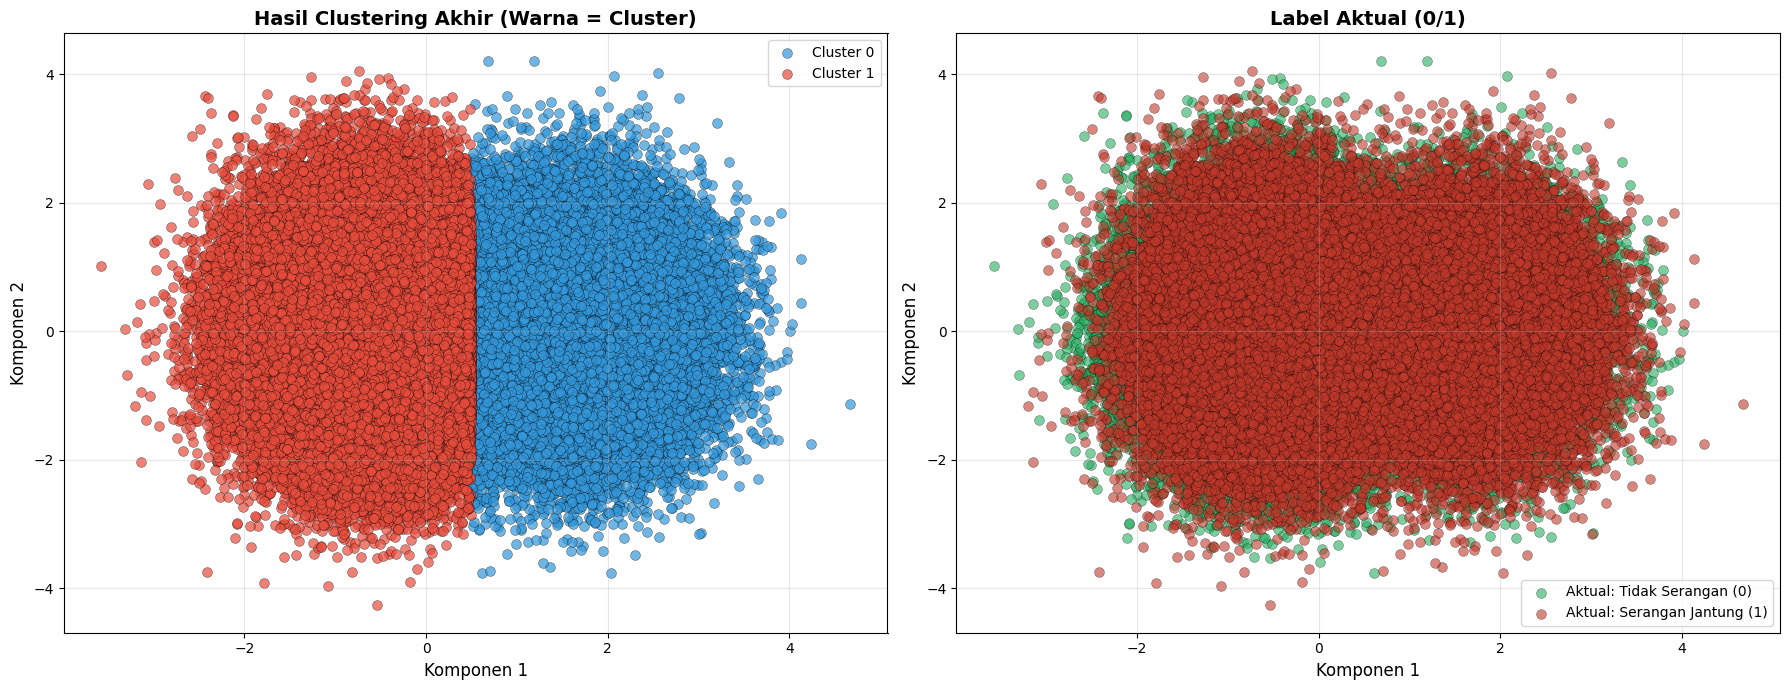


📊 CONFUSION MATRIX: Prediksi vs Aktual
Aktual        0      1     All
Prediksi                      
0         73575  40384  113959
1         21279  23117   44396
All       94854  63501  158355

📈 RATA-RATA FITUR NUMERIK PER CLUSTER
               age  hypertension  diabetes  cholesterol_level  obesity  \
cluster_raw                                                              
0            54.54           0.3       0.2             199.50     0.87   
1            54.54           0.3       0.2             199.55     0.01   

             waist_circumference  family_history  sleep_hours  \
cluster_raw                                                     
0                         107.55             0.3         6.50   
1                          87.71             0.3         6.47   

             blood_pressure_systolic  blood_pressure_diastolic  \
cluster_raw                                                      
0                             129.57                     79.52   
1         

In [ ]:
# Sel 6
if 'df' in locals() and 'predicted_label' in df.columns and 'X_processed' in locals():
    print("\n--- Langkah 6: Visualisasi dan Interpretasi Cluster ---")

    # Reduksi dimensi untuk visualisasi (TruncatedSVD untuk data berdimensi tinggi)
    from sklearn.decomposition import TruncatedSVD, PCA
    import scipy.sparse as sp

    # Pastikan bentuk padat
    Xp = X_processed

    # Pilih reducer
    if hasattr(Xp, 'toarray') or sp.issparse(Xp):
        reducer = TruncatedSVD(n_components=2, random_state=42)
        print("Menggunakan TruncatedSVD untuk reduksi dimensi")
    else:
        reducer = PCA(n_components=2, random_state=42)
        print("Menggunakan PCA untuk reduksi dimensi")

    X_2d = reducer.fit_transform(Xp)

    # Figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot 1: cluster hasil akhir
    cluster_colors = {0: '#3498db', 1: '#e74c3c', 2: '#9b59b6', 3: '#2ecc71', -1: '#95a5a6'}
    for cluster_id in sorted(df['cluster_raw'].unique()):
        mask = df['cluster_raw'] == cluster_id
        label_name = f"Cluster {cluster_id}"
        axes[0].scatter(X_2d[mask, 0], X_2d[mask, 1],
                        c=cluster_colors.get(int(cluster_id), '#95a5a6'),
                        label=label_name, s=50, alpha=0.7, edgecolors='k', linewidth=0.3)

    axes[0].set_title('Hasil Clustering Akhir (Warna = Cluster)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Komponen 1', fontsize=12)
    axes[0].set_ylabel('Komponen 2', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: label aktual
    label_colors = {0: '#27ae60', 1: '#c0392b'}
    label_names = {0: 'Tidak Serangan (0)', 1: 'Serangan Jantung (1)'}

    for label_val in [0, 1]:
        mask_actual = df['heart_attack'] == label_val
        axes[1].scatter(X_2d[mask_actual, 0], X_2d[mask_actual, 1],
                        c=label_colors[label_val], label=f'Aktual: {label_names[label_val]}',
                        s=50, alpha=0.6, marker='o', edgecolors='k', linewidth=0.3)

    axes[1].set_title('Label Aktual (0/1)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Komponen 1', fontsize=12)
    axes[1].set_ylabel('Komponen 2', fontsize=12)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Confusion Matrix / Crosstab
    print("\n" + "="*60)
    print("📊 CONFUSION MATRIX: Prediksi vs Aktual")
    print("="*60)
    crosstab = pd.crosstab(
        df['predicted_label'],
        df['heart_attack'],
        rownames=['Prediksi'],
        colnames=['Aktual'],
        margins=True
    )
    print(crosstab)

    # Profil fitur numerik per cluster (jika ada)
    # Ambil kembali daftar fitur numerik dari preprocessor jika tersedia
    try:
        from sklearn.compose import ColumnTransformer
        # numerical_features sudah disiapkan di Sel 3
        if 'numerical_features' in locals() and len(numerical_features) > 0:
            print("\n" + "="*60)
            print("📈 RATA-RATA FITUR NUMERIK PER CLUSTER")
            print("="*60)
            cols_ok = [c for c in numerical_features if c in df.columns]
            if cols_ok:
                cluster_profile = df.groupby('cluster_raw')[cols_ok].mean()
                print(cluster_profile.round(2))
    except Exception:
        pass

else:
    print("Clustering belum dijalankan, langkah ini dilewati.")

## Evaluasi Performa Clustering
Menghitung metrik evaluasi (Accuracy, Precision, Recall, F1-Score) untuk mengukur seberapa baik clustering DBSCAN memprediksi label serangan jantung.


--- Langkah 7: Evaluasi Performa Clustering ---

🎯 METRIK EVALUASI CLUSTERING DBSCAN (2 Cluster → 0/1)
Accuracy  : 0.6106 (61.06%)
Precision : 0.5207 (52.07%)
Recall    : 0.3640 (36.40%)
F1-Score  : 0.4285 (42.85%)

📋 CLASSIFICATION REPORT
                      precision    recall  f1-score   support

  Tidak Serangan (0)       0.65      0.78      0.70     94854
Serangan Jantung (1)       0.52      0.36      0.43     63501

            accuracy                           0.61    158355
           macro avg       0.58      0.57      0.57    158355
        weighted avg       0.60      0.61      0.59    158355



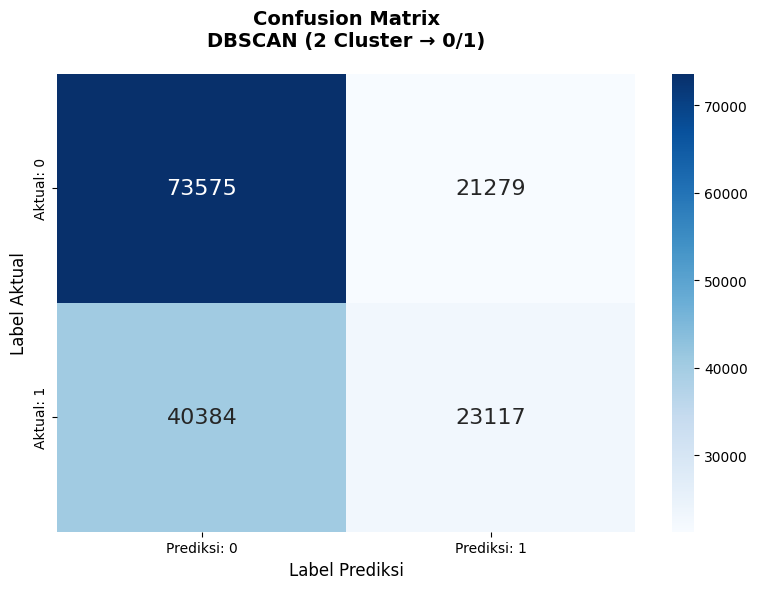


💡 INTERPRETASI HASIL
True Negative  (TN): 73575 → Benar prediksi TIDAK serangan
False Positive (FP): 21279 → Salah prediksi serangan (padahal tidak)
False Negative (FN): 40384 → Salah prediksi tidak serangan (padahal serangan)
True Positive  (TP): 23117 → Benar prediksi SERANGAN

✅ Selesai. Clustering menghasilkan tepat 2 cluster yang dipetakan ke 0/1.
   → Performa CUKUP ⚠️


In [ ]:
# Sel 7
if 'df' in locals() and 'predicted_label' in df.columns and 'heart_attack' in df.columns:
    print("\n--- Langkah 7: Evaluasi Performa Clustering ---")

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import classification_report, confusion_matrix

    y_true = df['heart_attack'].astype(int).values
    y_pred = df['predicted_label'].astype(int).values

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\n" + "="*60)
    print("🎯 METRIK EVALUASI CLUSTERING DBSCAN (2 Cluster → 0/1)")
    print("="*60)
    print(f"Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision : {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall    : {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score  : {f1:.4f} ({f1*100:.2f}%)")

    # Classification Report Detail
    print("\n" + "="*60)
    print("📋 CLASSIFICATION REPORT")
    print("="*60)
    target_names = ['Tidak Serangan (0)', 'Serangan Jantung (1)']
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    # Confusion Matrix Visual
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Prediksi: 0', 'Prediksi: 1'],
                yticklabels=['Aktual: 0', 'Aktual: 1'],
                ax=ax, annot_kws={"size": 16})
    ax.set_title('Confusion Matrix\nDBSCAN (2 Cluster → 0/1)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Label Aktual', fontsize=12)
    ax.set_xlabel('Label Prediksi', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Interpretasi hasil
    print("\n" + "="*60)
    print("💡 INTERPRETASI HASIL")
    print("="*60)

    tn, fp, fn, tp = cm.ravel()
    print(f"True Negative  (TN): {tn} → Benar prediksi TIDAK serangan")
    print(f"False Positive (FP): {fp} → Salah prediksi serangan (padahal tidak)")
    print(f"False Negative (FN): {fn} → Salah prediksi tidak serangan (padahal serangan)")
    print(f"True Positive  (TP): {tp} → Benar prediksi SERANGAN")

    print(f"\n✅ Selesai. Clustering menghasilkan tepat 2 cluster yang dipetakan ke 0/1.")

    if accuracy >= 0.8:
        print("   → Performa SANGAT BAIK! 🎉")
    elif accuracy >= 0.7:
        print("   → Performa BAIK 👍")
    elif accuracy >= 0.6:
        print("   → Performa CUKUP ⚠️")
    else:
        print("   → Performa perlu ditingkatkan. Coba jalankan ulang grid-search atau ubah kandidat eps/min_samples.")
else:
    print("Clustering belum dijalankan, langkah ini dilewati.")

## Kesimpulan DBSCAN

### Kesimpulan Utama
- DBSCAN berhasil membentuk cluster dan dipetakan menjadi label biner (0 = Tidak Serangan, 1 = Serangan).
- Performa dievaluasi menggunakan Accuracy, Precision, Recall, dan F1-Score (lihat output pada Langkah 7).
- Silhouette Score ditambahkan untuk menilai kualitas pemisahan dan kekompakan cluster secara unsupervised:
  - > 0.50: pemisahan antar-cluster baik (struktur cluster kuat).
  - 0.20 – 0.50: cukup, masih mungkin ada tumpang tindih antar-cluster.
  - 0.00 – 0.20: lemah, cluster kurang terdefinisi dengan baik.
  - < 0.00: buruk, indikasi cluster tidak tepat atau parameter perlu disetel ulang.
- Visualisasi membantu memeriksa apakah pola cluster selaras dengan label aktual (0/1).

### Interpretasi Metrik
- Accuracy: proporsi prediksi yang benar secara keseluruhan.
- Precision: dari yang diprediksi “serangan”, berapa yang benar-benar serangan (kontrol false positive).
- Recall: dari semua kasus “serangan” aktual, berapa yang berhasil terdeteksi (kontrol false negative).
- F1-Score: harmonisasi precision dan recall (berguna saat kelas tidak seimbang).
- Silhouette: kualitas struktur cluster tanpa memandang label; melengkapi metrik supervised di atas.

### Rekomendasi Peningkatan
1) Penyelarasan Parameter DBSCAN
- Tinjau kembali kandidat `eps` dan `min_samples`. Untuk Silhouette rendah/negatif, pertimbangkan:
  - Kurangi/tingkatkan `eps` agar density tetangga lebih sesuai.
  - Sesuaikan `min_samples` relatif terhadap dimensi dan ukuran data.

2) Fitur & Pra-pemrosesan
- Coba seleksi/rekayasa fitur (feature engineering) yang relevan secara medis.
- Pertimbangkan transformasi tambahan atau penghilangan fitur yang sangat bising.

3) Penanganan Ketidakseimbangan Kelas
- Jika distribusi 0/1 tidak seimbang, gunakan teknik penyeimbangan (mis. undersampling/oversampling) pada pipeline pembelajaran berbasis label (untuk perbandingan).

4) Alternatif/Perbandingan Metode
- Bandingkan dengan KMeans, HDBSCAN, atau algoritme lain untuk melihat konsistensi pola.
- Evaluasi juga metrik internal lain (Davies–Bouldin, Calinski–Harabasz) untuk gambaran menyeluruh.

5) Validasi & Interpretabilitas
- Lakukan validasi silang pada pendekatan berbasis label untuk baseline terawasi.
- Gunakan analisis fitur penting atau SHAP pada model terawasi pembanding untuk wawasan faktor risiko.


# Kesimpulan Perbandingan KMeans dan DBSCAN

* **K-Means** memberikan segmentasi makro yang **interpretabel** (dua klaster) dengan profil risiko yang konsisten. Klaster berisiko tinggi ditandai oleh **rerata obesitas dan lingkar pinggang yang lebih besar**. Namun, **kualitas struktur klaster lemah** (Silhouette = 0,0717; proyeksi PCA tumpang tindih), dan **validasi eksternal** terhadap *heart_attack* menunjukkan **akurasi sedang** (≈0,62) tetapi **recall rendah** (≈0,34), mengindikasikan banyak kasus positif tidak terjaring. Dengan demikian, K-Means **lebih tepat untuk cohorting/segmentasi** daripada pemodelan prediktif kejadian klinis.

* **DBSCAN** efektif untuk **mengenali bentuk klaster non-sferis** dan **menandai outlier/noise** tanpa memaksa seluruh titik ke dalam klaster. Akan tetapi, kinerjanya **sangat bergantung** pada penalaan **`eps`** dan **`min_samples`**; tanpa pengaturan yang tepat, kualitas pemisahan cenderung rendah. Dalam konteks ini, *noise* sebaiknya diperlakukan sebagai **kasus ambigu** yang memerlukan **peninjauan lanjutan** alih-alih disimpulkan sebagai non-risiko.

* Secara strategis, **pendekatan komplementer** direkomendasikan: gunakan **DBSCAN** untuk *flagging/penyaringan* titik ambigu dan **K-Means** untuk **cohorting** yang mudah dikomunikasikan, kemudian **lanjutkan dengan model terawasi** (mis. Logistic Regression/XGBoost) untuk prediksi kejadian dengan evaluasi **AUC, PR-AUC, recall@k**, serta interpretasi fitur (mis. SHAP). Mengembalikan **fitur klinis relevan** (mis. usia, hasil EKG) pada tahap terawasi berpotensi meningkatkan keselarasan dengan label.

* Implikasi metodologis: **Silhouette yang rendah** dan **overlap PCA** menandakan **struktur intrinsik yang lemah** dalam ruang fitur saat ini; pemetaan klaster ke label bersifat **heuristik**. Oleh sebab itu, perbaikan sebaiknya difokuskan pada **rekayasa/seleksi fitur**, **penyelarasan parameter DBSCAN** melalui *grid search* berskala kecil, serta **validasi menyilang** pada pendekatan terawasi untuk memperoleh **ketepatan klinis yang lebih tinggi**.
